# Fine Tuning Mask RCNN for Pedestrian detection

### Download and unzip Penn Fudan Dataset

In [1]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip /content/PennFudanPed.zip


--2020-07-23 17:11:32--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  1009KB/s    in 48s     

2020-07-23 17:12:21 (1.06 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  /content/PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed

In [54]:
import os
import torch 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


### Creating custom class to load Dataset

In [19]:

class PennDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
        mask = Image.open(mask_path)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../


Cloning into 'vision'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 9278 (delta 7), reused 3 (delta 0), pack-reused 9258
Receiving objects: 100% (9278/9278), 11.24 MiB | 9.66 MiB/s, done.
Resolving deltas: 100% (6426/6426), done.


In [6]:
from torchvision import transforms, models
import transforms as T
def get_transform(train):
    transform = []
    transform.append(T.ToTensor())
    if train:
        transform.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transform)

In [20]:
data_dir= '/content/PennFudanPed'
dataset = PennDataset(data_dir, get_transform(train=True))
dataset_test = PennDataset(data_dir, get_transform(train=False))
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
print(len(dataset))
print(len(dataset_test))

120
50


In [21]:
import utils

data_loader= torch.utils.data.DataLoader(dataset, shuffle= True, 
                                       batch_size=2, num_workers= 4,
                                       collate_fn = utils.collate_fn)
data_loader_test= torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=2,
                                      num_workers=4, collate_fn= utils.collate_fn)

### Fine tuning MaskRCNN-Resnet50-fpn to detect 2 classes only(background and person)

In [11]:
def get_model_instance(num_classes):
    model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    #print(model)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer= 256
    model.roi_heads.mask_predictor = models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask,
                                                                                  hidden_layer,
                                                                                  num_classes)
    
    return model

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_classes = 2
model = get_model_instance(num_classes)
print(model)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth



MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequenti

In [13]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005,
                            momentum = 0.9, weight_decay = 0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                        step_size =3,
                                        gamma= 0.1)

In [22]:
from engine import train_one_epoch, evaluate
num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f329da24320>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f329da24320>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x

Epoch: [0]  [ 0/60]  eta: 0:02:13  lr: 0.000090  loss: 3.3393 (3.3393)  loss_classifier: 0.7263 (0.7263)  loss_box_reg: 0.2501 (0.2501)  loss_mask: 2.3082 (2.3082)  loss_objectness: 0.0427 (0.0427)  loss_rpn_box_reg: 0.0120 (0.0120)  time: 2.2294  data: 0.8746  max mem: 2588
Epoch: [0]  [10/60]  eta: 0:00:43  lr: 0.000936  loss: 1.8116 (2.1195)  loss_classifier: 0.4723 (0.4726)  loss_box_reg: 0.1616 (0.1659)  loss_mask: 1.1667 (1.4385)  loss_objectness: 0.0262 (0.0321)  loss_rpn_box_reg: 0.0112 (0.0104)  time: 0.8607  data: 0.0825  max mem: 2858
Epoch: [0]  [20/60]  eta: 0:00:32  lr: 0.001783  loss: 0.7650 (1.4122)  loss_classifier: 0.2145 (0.3239)  loss_box_reg: 0.1516 (0.1537)  loss_mask: 0.3945 (0.8993)  loss_objectness: 0.0175 (0.0237)  loss_rpn_box_reg: 0.0106 (0.0116)  time: 0.7335  data: 0.0055  max mem: 2859
Epoch: [0]  [30/60]  eta: 0:00:24  lr: 0.002629  loss: 0.5252 (1.1140)  loss_classifier: 0.0967 (0.2482)  loss_box_reg: 0.1251 (0.1520)  loss_mask: 0.2100 (0.6831)  loss_ob

### Inference

In [27]:
model.eval()
img, _ =dataset_test[10]
with torch.no_grad():
    pred= model([img.to(device)])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [28]:
pred

[{'boxes': tensor([[339.9421,  89.0737, 427.4004, 349.7884],
          [ 24.6851,  72.6762, 148.5253, 376.6062],
          [235.3533,  80.1065, 313.7231, 391.0782],
          [147.3481,  77.0613, 246.2309, 376.7336],
          [ 14.1736,  56.9845,  62.3244, 177.9852]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  .

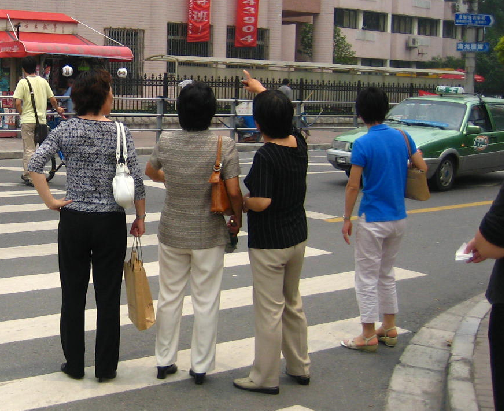

In [29]:
Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy())

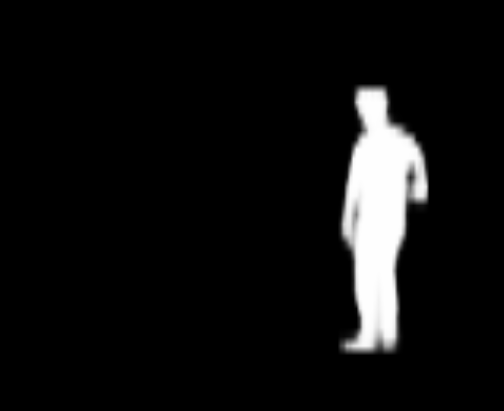

In [34]:
Image.fromarray(pred[0]['masks'][0,0].mul(255).byte().cpu().numpy())

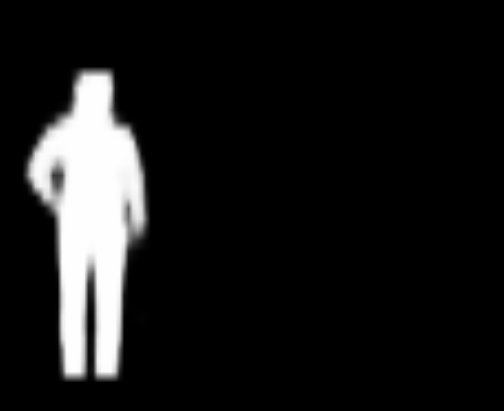

In [36]:
Image.fromarray(pred[0]['masks'][1,0].mul(255).byte().cpu().numpy())

In [52]:
def create_corner_rect(bb, color='red'):
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    im = im.cpu().numpy()
    im = im.transpose(1,2,0)
    print(im.shape)
    plt.imshow(im)
    for i in range(len(bb)):
        plt.gca().add_patch(create_corner_rect(bb[i]))

(411, 504, 3)


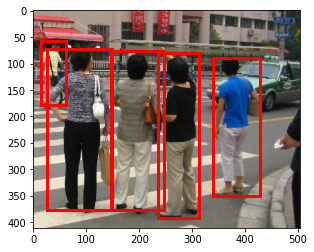

In [53]:
show_corner_bb(img, pred[0]['boxes'].cpu().numpy())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


(397, 396, 3)


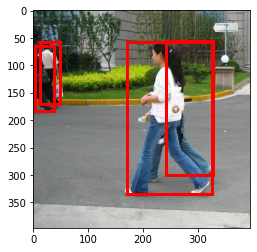

In [56]:
img, _ =dataset_test[5]
with torch.no_grad():
    pred = model([img.to(device)])
show_corner_bb(img, pred[0]['boxes'].cpu().numpy())
